vit_small_patch14_reg4_dinov2


Text(0.5, 1.0, 'Fear: 70/100')

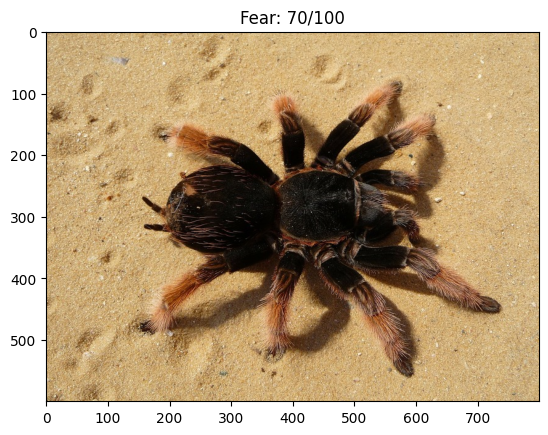

In [7]:
import os
import pickle
import io
from model_loader import create_model
from pathlib import Path
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from transforms import get_data_transforms


DATA_DIR = Path("/home", "user", "Dropbox", "data_export", "spidernets-analysis")
EXP_DIR = Path(DATA_DIR, "experiments")
img_path = Path(DATA_DIR, "stimuli", "Sp_040.jpg")

# run_id ="0022"
run_id ="2801"
fold = 1
is_transformer = True

transform = get_data_transforms(224, use_bicubic=is_transformer)["val"]

with open(Path(EXP_DIR, run_id, "run_config.json")) as fp:
    run_config = json.load(fp)

img_ar = cv2.imread(img_path)
img_ar = cv2.cvtColor(img_ar, cv2.COLOR_BGR2RGB)
img = Image.fromarray(img_ar)
img = transform(img).unsqueeze(0)

m = create_model(run_config, n_layers=3, dropout=0, data_dir=DATA_DIR)

class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

checkpoint_path = Path(EXP_DIR, run_id, f"fold_{fold}", "checkpoint_fine_tuning.pth")

with open(checkpoint_path, "rb") as fp:
    checkpoint = CPU_Unpickler(fp).load()

m.load_state_dict(checkpoint)

m.eval();

with torch.no_grad():
    output = m(img)
    output = output.cpu().numpy().squeeze()

# del m
print(run_config["model_name"])
plt.imshow(img_ar)
plt.title(f"Fear: {output:.0f}/100")

In [3]:
m_onnx = torch.onnx.export(m, img, dynamo=True)

[torch.onnx] Obtain model graph for `VisionTransformer([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `VisionTransformer([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅


In [4]:
m_onnx.save("model.onnx")
